In [328]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [420]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RepeatedStratifiedKFold
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier

from tensorflow.keras.utils import to_categorical

In [330]:
#Load csv
df = pd.read_csv("./dataset/tbpred.csv")
print(df.nunique())

Name                  1981
Gender                   2
Age                     96
Country of Birth       243
Smoking                  5
Alcohol                  5
Family History           2
Close Contact            2
Health Conditions        2
Occupational Risks       2
Physical Activity        5
Diet                     2
Air Pollution            5
Long Term Cough          2
Chest Pain               2
Appetite Loss            2
Weight Loss              2
Chills                   2
Fatigue                  2
Night Sweat              2
Cough Blood              2
Fevers                   2
Nitric Oxide          1687
tb_pred                  2
dtype: int64


In [331]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Name                2000 non-null   object 
 1   Gender              2000 non-null   object 
 2   Age                 2000 non-null   int64  
 3   Country of Birth    2000 non-null   object 
 4   Smoking             2000 non-null   int64  
 5   Alcohol             2000 non-null   int64  
 6   Family History      2000 non-null   int64  
 7   Close Contact       2000 non-null   int64  
 8   Health Conditions   2000 non-null   int64  
 9   Occupational Risks  2000 non-null   int64  
 10  Physical Activity   2000 non-null   int64  
 11  Diet                2000 non-null   int64  
 12  Air Pollution       2000 non-null   int64  
 13  Long Term Cough     2000 non-null   int64  
 14  Chest Pain          2000 non-null   int64  
 15  Appetite Loss       2000 non-null   int64  
 16  Weight

In [332]:
print(df.isnull().sum())
print('Total number of duplicated rows: ', df.duplicated().sum())

Name                  0
Gender                0
Age                   0
Country of Birth      0
Smoking               0
Alcohol               0
Family History        0
Close Contact         0
Health Conditions     0
Occupational Risks    0
Physical Activity     0
Diet                  0
Air Pollution         0
Long Term Cough       0
Chest Pain            0
Appetite Loss         0
Weight Loss           0
Chills                0
Fatigue               0
Night Sweat           0
Cough Blood           0
Fevers                0
Nitric Oxide          0
tb_pred               0
dtype: int64
Total number of duplicated rows:  0


In [333]:
df_cat = df[['Name', 'Gender', 'Country of Birth']]

In [334]:
#Label Encode 'Country of Birth' 
le = preprocessing.LabelEncoder()
df['encoded_country'] = le.fit_transform(df['Country of Birth'])

print(df.sample(5))

                    Name  Gender  Age Country of Birth  Smoking  Alcohol  \
767       Barbara Miller    male   46      Netherlands        1        2   
104   Joshua Osborne DDS    male   65  North Macedonia        0        2   
1999     Rebekah Chapman    male   96          Georgia        0        3   
338          Wesley King  female   18            Niger        2        0   
597       Shawna Hoffman    male   34            Korea        3        4   

      Family History  Close Contact  Health Conditions  Occupational Risks  \
767                0              1                  0                   1   
104                0              0                  0                   1   
1999               1              1                  0                   0   
338                1              0                  1                   1   
597                0              0                  0                   1   

      ...  Appetite Loss  Weight Loss  Chills  Fatigue  Night Sweat  \
767

In [335]:
#One Hot Encode 'Gender' 
df_encoded = pd.get_dummies(data = df, columns=['Gender'])
df_encoded['Gender_male'] = df_encoded['Gender_male'].astype(int)
df_encoded['Gender_female'] = df_encoded['Gender_female'].astype(int)
print(df_encoded.sample(5))

                  Name  Age       Country of Birth  Smoking  Alcohol  \
1784      Jason Harris   73                 France        0        3   
1855  Stephen Friedman   89             Kazakhstan        0        1   
1169    Renee Reynolds   59  Saint Kitts and Nevis        0        1   
1717  Mr. Austin Lopez   49               Cameroon        0        2   
1155       John French   63                Uruguay        2        2   

      Family History  Close Contact  Health Conditions  Occupational Risks  \
1784               1              1                  0                   0   
1855               1              1                  1                   1   
1169               1              1                  0                   0   
1717               1              1                  0                   1   
1155               0              0                  1                   1   

      Physical Activity  ...  Chills  Fatigue  Night Sweat  Cough Blood  \
1784                  3

In [336]:
X = df_encoded.drop(['Name','Country of Birth'], axis=1)
print(X.sample(5))

      Age  Smoking  Alcohol  Family History  Close Contact  Health Conditions  \
1776   15        1        0               1              0                  1   
278    83        4        4               0              1                  0   
999    19        2        2               1              1                  0   
631    44        3        2               1              0                  1   
567     5        3        4               1              1                  1   

      Occupational Risks  Physical Activity  Diet  Air Pollution  ...  Chills  \
1776                   1                  4     0              1  ...       0   
278                    0                  3     0              0  ...       1   
999                    1                  2     0              3  ...       1   
631                    1                  2     0              2  ...       1   
567                    0                  1     0              3  ...       1   

      Fatigue  Night Sweat

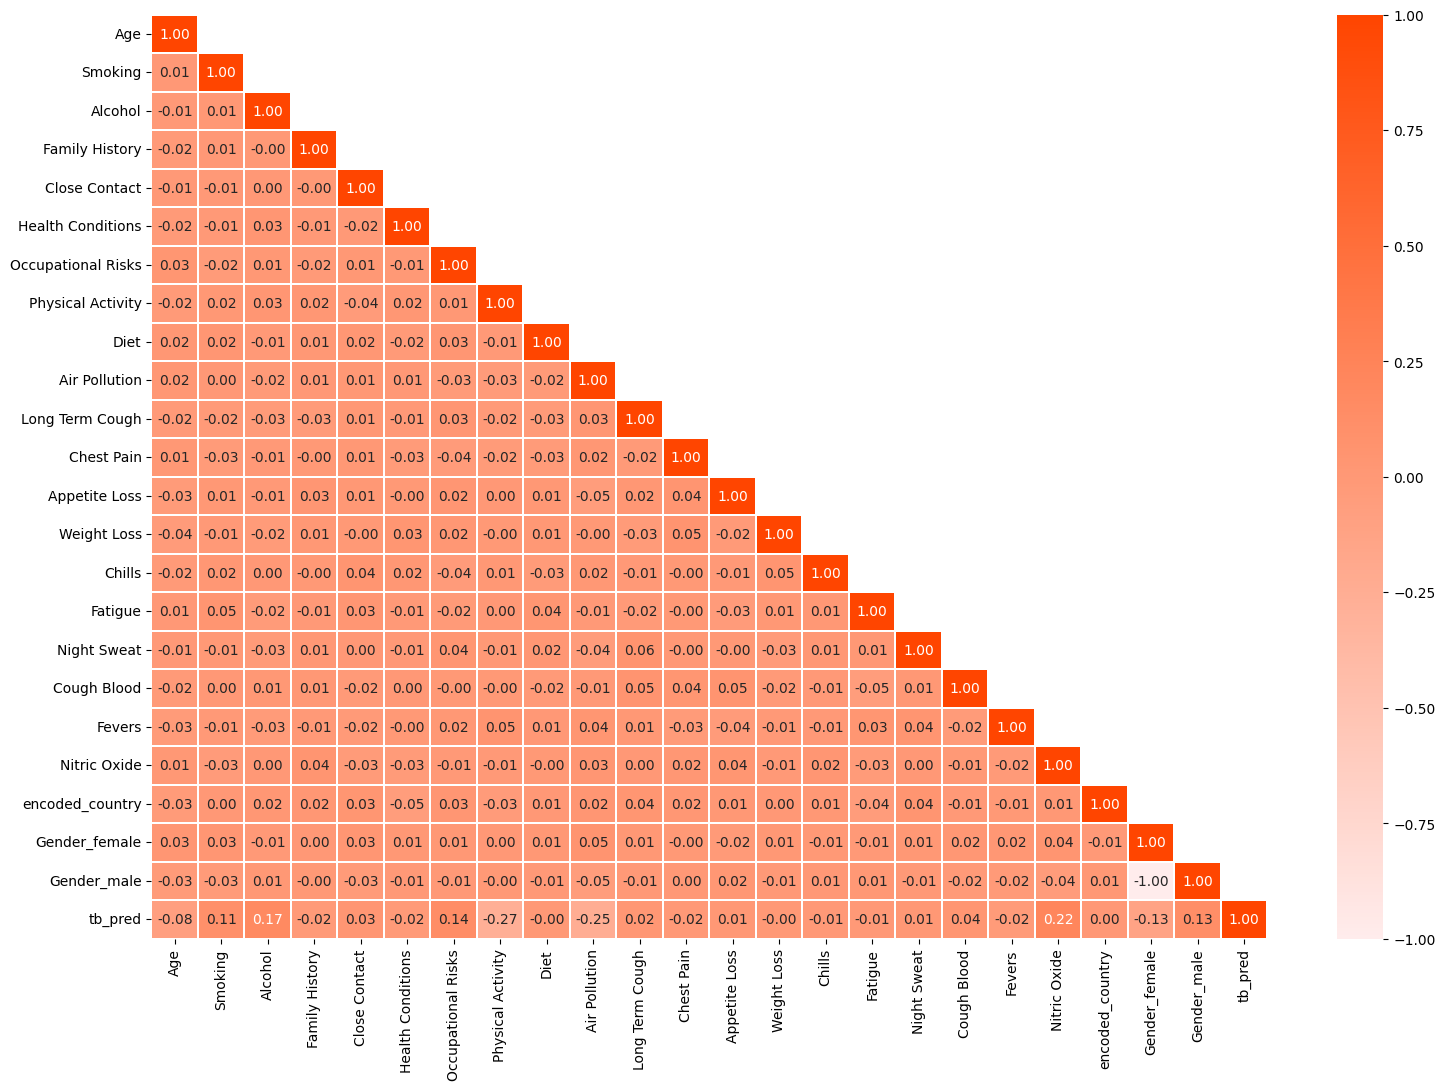

In [337]:
# Define a colormap
orangered_cmap = LinearSegmentedColormap.from_list('orangered', ['#FFECEC','orangered'])

# Calculation of the Spearman correlation
target = 'tb_pred'
df_ordered = pd.concat([X.drop(target,axis=1), X[target]],axis=1)
corr = df_ordered.corr()

# Create a mask so that we see the correlation values only once
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask,1)] = True

# Plot the heatmap correlation
plt.figure(figsize=(18,12))
sns.heatmap(corr, mask=mask, annot=True, cmap=orangered_cmap, fmt='.2f', linewidths=0.2)
plt.show()

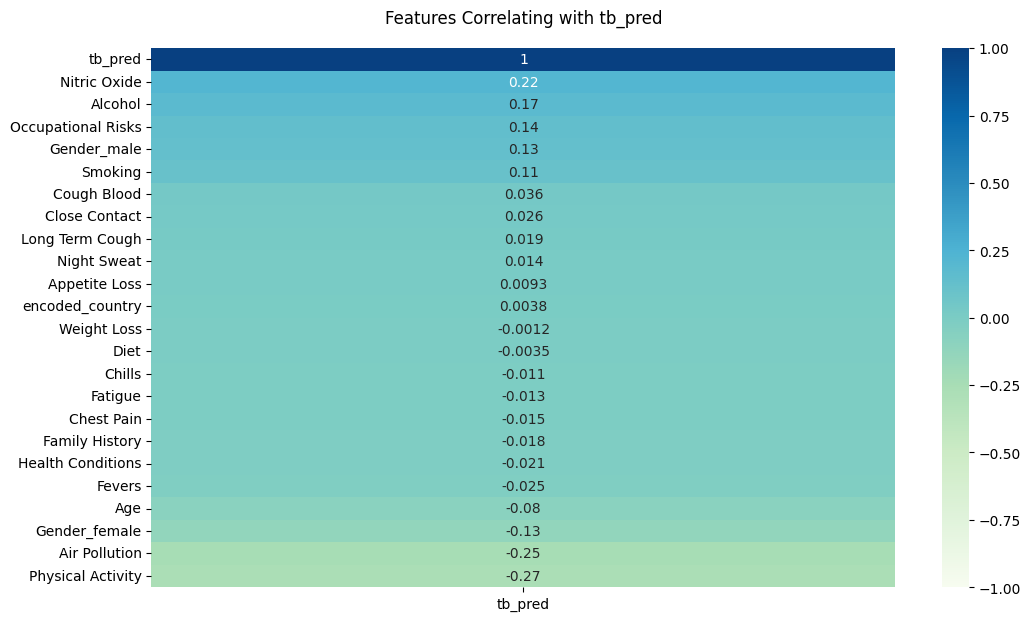

In [338]:
plt.figure (figsize = (12, 7), dpi = 100)
heatmap = sns.heatmap (X.corr()[['tb_pred']].sort_values (by = 'tb_pred', ascending = False), vmin = -1, vmax = 1, annot = True, cmap = 'GnBu')
heatmap.set_title ('Features Correlating with tb_pred', fontdict = {'fontsize':12}, pad = 18);

In [339]:
print(X['tb_pred'].value_counts())

tb_pred
0    1536
1     464
Name: count, dtype: int64


## Training

### Using SVM

In [340]:
X1 = X.drop('tb_pred', axis=1)
Y1 = X['tb_pred']

In [341]:
print(X1.shape)
print(Y1.shape)

(2000, 23)
(2000,)


In [342]:
scaler = MinMaxScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X1), columns=X1.columns)

In [343]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y1, test_size = 0.15)

print(X_train.shape)
print(X_test.shape)

print(y_train.shape)
print(y_test.shape)

(1700, 23)
(300, 23)
(1700,)
(300,)


In [344]:
kern = ['linear','rbf','poly']
for ke in kern:
    model = SVC(kernel=ke, C=300)
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)

    # Model Accuracy: how often is the classifier correct?
    print(ke+" accuracy: ", metrics.accuracy_score(y_test, y_pred))

linear accuracy:  0.85
rbf accuracy:  0.8
poly accuracy:  0.72


In [345]:
for num in range(100, 600, 100):
    model = SVC(kernel='linear', C=num)
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)

    # Model Accuracy: how often is the classifier correct?
    print(num, " accuracy: ", metrics.accuracy_score(y_test, y_pred))

100  accuracy:  0.85
200  accuracy:  0.85
300  accuracy:  0.85
400  accuracy:  0.85
500  accuracy:  0.85


In [346]:
model = SVC(kernel='linear', C=300)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)

In [347]:
# Calculate the percentage of True and False predictions
percentage_true = (y_pred == 1).sum() / len(y_pred) * 100
percentage_false = (y_pred == 0).sum() / len(y_pred) * 100

# Display the percentages
print(f"Percentage of True Predictions: {percentage_true:.2f}%")
print(f"Percentage of False Predictions: {percentage_false:.2f}%")

Percentage of True Predictions: 13.33%
Percentage of False Predictions: 86.67%


### Using KNN

In [318]:
X2 = X[['Gender_male','Alcohol','Smoking','Nitric Oxide','Family History']]

In [319]:
scaler = preprocessing.StandardScaler()

X1_scaled = scaler.fit_transform(X1)

X1_scaled = pd.DataFrame(X1_scaled)

X1_train,X1_test,y1_train,y1_test = train_test_split(X1_scaled, Y1, test_size = .3,random_state=5)

Text(0, 0.5, 'Accuracy')

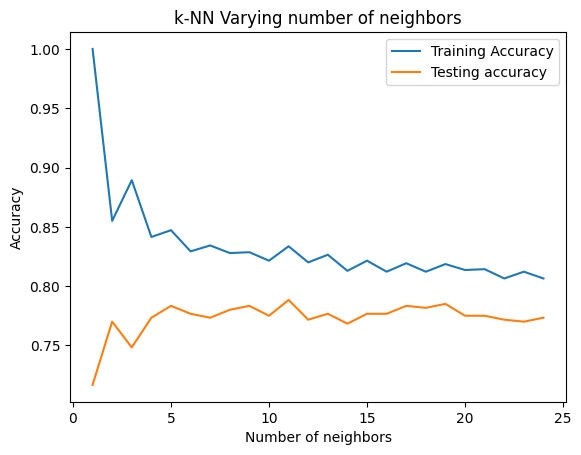

In [320]:
#Try running from k=1 through 25 and record testing accuracy
k_range = range(1,25)
scores_list = []
error_list = []
train_accuracy =np.empty(len(k_range))
test_accuracy = np.empty(len(k_range))
for k in k_range:
        knn = KNeighborsClassifier(n_neighbors=k, weights='uniform')
        knn.fit(X1_train,y1_train)
        #y_pred=knn.predict(X_test)
        #scores[k] = metrics.accuracy_score(y_test,y_pred)
        #scores_list.append(metrics.accuracy_score(y_test,y_pred))
        #error_list.append(np.mean(y_pred != y_test))
        train_accuracy[k-1] = knn.score(X1_train, y1_train)
        test_accuracy[k-1] = knn.score(X1_test, y1_test)

plt.title('k-NN Varying number of neighbors')
plt.plot(k_range,train_accuracy, label='Training Accuracy')
plt.plot(k_range,test_accuracy, label='Testing accuracy')
plt.legend()
plt.xlabel('Number of neighbors')
plt.ylabel('Accuracy')

Text(0, 0.5, 'Accuracy')

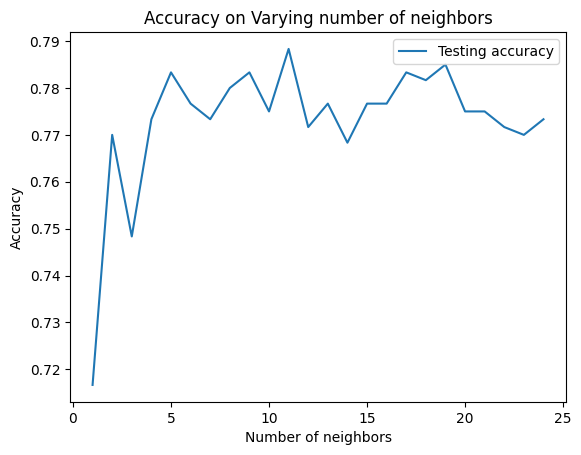

In [321]:
plt.title('Accuracy on Varying number of neighbors')
plt.plot(k_range,test_accuracy, label='Testing accuracy')
plt.legend()
plt.xlabel('Number of neighbors')
plt.ylabel('Accuracy')

In [322]:
knn1 = KNeighborsClassifier(n_neighbors=5, weights='uniform')

knn1.fit(X1_train,y1_train)

y_pred1 = knn1.predict(X1_test)

score = metrics.accuracy_score(y1_test, y_pred1)

print("Accuracy: ", score)

Accuracy:  0.7833333333333333


### Multi Class Classification

In [323]:
# Fitting Logistic Regression to the Training set
classifier = LogisticRegression(solver='liblinear', random_state = 0)
classifier.fit(X1, Y1)

LogisticRegression(random_state=0, solver='liblinear')

In [324]:
y_pred2=classifier.predict(X1)

accuracy = metrics.accuracy_score(Y1, y_pred2)
print("train accuracy: %.2f." %accuracy)

precision = metrics.precision_score(Y1, y_pred2, average='macro')
print("train precision: %.2f." %precision)

recall = metrics.recall_score(Y1, y_pred2, average='macro')
print("train recall: %.2f." %recall)

print(y_pred2[:100])

train accuracy: 0.83.
train precision: 0.78.
train recall: 0.72.
[1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0 1 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]


In [325]:
# Calculate the percentage of True and False predictions
percentage_true = (y_pred2 == 1).sum() / len(y_pred2) * 100
percentage_false = (y_pred2 == 0).sum() / len(y_pred2) * 100

# Display the percentages
print(f"Percentage of True Predictions: {percentage_true:.2f}%")
print(f"Percentage of False Predictions: {percentage_false:.2f}%")

Percentage of True Predictions: 16.60%
Percentage of False Predictions: 83.40%


## DNN

In [353]:
cmodel = tf.keras.models.Sequential()

cmodel.add(tf.keras.Input(shape=[X1.shape[1]]))

cmodel.add(tf.keras.layers.Dense(15, activation='relu'))

cmodel.add(tf.keras.layers.Dense(10, activation='relu'))

# Assuming num_classes is the number of unique classes in your data
num_classes = len(set(Y1))
cmodel.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

print(cmodel.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 15)                360       
                                                                 
 dense_1 (Dense)             (None, 10)                160       
                                                                 
 dense_2 (Dense)             (None, 2)                 22        
                                                                 
Total params: 542 (2.12 KB)
Trainable params: 542 (2.12 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [354]:
# Encode categorical target variable
encoder = preprocessing.LabelEncoder()
y_train_encoded = encoder.fit_transform(y_train)
num_classes = len(encoder.classes_)

y_train_one_hot = tf.keras.utils.to_categorical(y_train_encoded, num_classes=num_classes)

In [355]:
optimizer = tf.keras.optimizers.Adam()

cmodel.compile(loss= 'categorical_crossentropy', optimizer= optimizer, metrics=['accuracy'])

In [356]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

chistory = cmodel.fit(X_train, y_train_one_hot, batch_size=8, epochs=150,validation_split = 0.2, verbose=0, callbacks=[early_stop])

In [357]:
# Encode categorical target variable
encoder1 = preprocessing.LabelEncoder()
y_test_encoded = encoder1.fit_transform(y_test)
num_classes1 = len(encoder1.classes_)

# One-hot encode the labels
y_test_one_hot = tf.keras.utils.to_categorical(y_test_encoded, num_classes=num_classes1)

# Evaluate the model
score = cmodel.evaluate(X_test, y_test_one_hot, verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

10/10 [==============================] - 0s 3ms/step - loss: 0.3746 - accuracy: 0.8533
Test Score: 0.37457820773124695
Test Accuracy: 0.8533333539962769


In [359]:
cpredict = cmodel.predict(X_test)
print(cpredict[:10])

10/10 [==============================] - 0s 3ms/step
[[7.2782916e-01 2.7217081e-01]
 [3.2534057e-01 6.7465943e-01]
 [7.3802036e-01 2.6197961e-01]
 [9.7669536e-01 2.3304604e-02]
 [9.9957281e-01 4.2722965e-04]
 [9.8857772e-01 1.1422318e-02]
 [8.5102898e-01 1.4897105e-01]
 [8.9132553e-01 1.0867441e-01]
 [9.7179103e-01 2.8208958e-02]
 [9.3757862e-01 6.2421363e-02]]


In [360]:
print(classification_report(np.argmax(y_test_one_hot, axis=1),np.argmax(cpredict, axis=1)))

              precision    recall  f1-score   support

           0       0.86      0.97      0.91       235
           1       0.78      0.45      0.57        65

    accuracy                           0.85       300
   macro avg       0.82      0.71      0.74       300
weighted avg       0.85      0.85      0.84       300



## Decision Tree

In [369]:
#Train model
dt_classifier = DecisionTreeClassifier(random_state=20)
dt_classifier.fit(X_train, y_train)

DecisionTreeClassifier(random_state=20)

In [370]:
prediction_dt = dt_classifier.predict(X_train)
accuracy_dt = accuracy_score(y_train, prediction_dt)
print(f"Train Accuracy: {accuracy_dt}")
predictions_dt = dt_classifier.predict(X_test)
accuracy_dt = accuracy_score(y_test, predictions_dt)
print(f"Test Accuracy: {accuracy_dt}")

Train Accuracy: 1.0
Test Accuracy: 0.9033333333333333


In [371]:
X3 = X.drop('tb_pred', axis=1)
Y3 = X['tb_pred'].values.reshape(-1, 1)

In [372]:
# Check the shape of X and y
print ('X:', X3.shape,'\nY:', Y3.shape)

X: (2000, 23) 
Y: (2000, 1)


In [373]:
# Array of test size value from 0.2 to 0.3
test_size = np.arange(start=0.2, stop=0.35, step= 0.05)

# Initialize a list where we'll store the score of each test size
score =[]
for size in test_size:
    X_train2, X_test2, y_train2, y_test2 = train_test_split (X3, Y3, test_size=size, random_state=0)
    DT_Clf = DecisionTreeClassifier (max_depth=3)
    DT_Clf.fit (X_train2, y_train2)
    score.append (DT_Clf.score (X_test2, y_test2))

# Create a dataframe to display the results 
r= pd.DataFrame({'Test size': test_size , 'Score': score})
r.sort_values(by = ['Score'], ascending = False, inplace = True)
r.style.highlight_max(color='#acd9a8')

In [374]:
# Split X and y into training and testing sets
X_train2, X_test2, y_train2, y_test2 = train_test_split (X3, Y3, stratify=Y2, test_size = 0.25, random_state = 0)

In [376]:
# check the shape of X_train, X_test, y_train and y_test
print('X_train shape: ', X_train2.shape)
print('X_test shape: ', X_test2.shape)
print('y_train shape: ', y_train2.shape)
print('y_test shape: ', y_test2.shape)

X_train shape:  (1500, 23)
X_test shape:  (500, 23)
y_train shape:  (1500, 1)
y_test shape:  (500, 1)


In [377]:
# Instantiate the model
DT_model = DecisionTreeClassifier(max_depth=3)

# Fit the model to the training set
DT_model.fit(X_train2, y_train2)

DecisionTreeClassifier(max_depth=3)

In [378]:
y_pred3 = DT_model.predict(X_test2)

In [379]:
print('Model accuracy score: {0:0.4f}'. format(accuracy_score(y_test2, y_pred3)))

Model accuracy score: 0.8420


In [381]:
# print the scores on training and test set
print('Training set score: {:.4f}'.format(DT_model.score(X_train2, y_train2)))
print('Test set score: {:.4f}'.format(DT_model.score(X_test2, y_test2)))

Training set score: 0.8520
Test set score: 0.8420


In [382]:
print(classification_report(y_test2, y_pred3))

              precision    recall  f1-score   support

           0       0.85      0.96      0.90       384
           1       0.77      0.46      0.57       116

    accuracy                           0.84       500
   macro avg       0.81      0.71      0.74       500
weighted avg       0.83      0.84      0.83       500



In [383]:
def metrics_calculator(y_test, y_pred, model_name):
    '''
    This function calculates all desired performance metrics for a given model.
    '''
    result = pd.DataFrame(data=[accuracy_score(y_test, y_pred),
                                precision_score(y_test, y_pred, average='macro'),
                                recall_score(y_test, y_pred, average='macro'),
                                f1_score(y_test, y_pred, average='macro')],
                          index=['Accuracy','Precision','Recall','F1-score'],
                          columns = [model_name])
    return result

In [384]:
BaseDT_result = metrics_calculator(y_test2, y_pred3, 'Base Decision Tree')
BaseDT_result

Base Decision Tree
Accuracy             0.842000
Precision            0.810972
Recall               0.707615
F1-score             0.738020

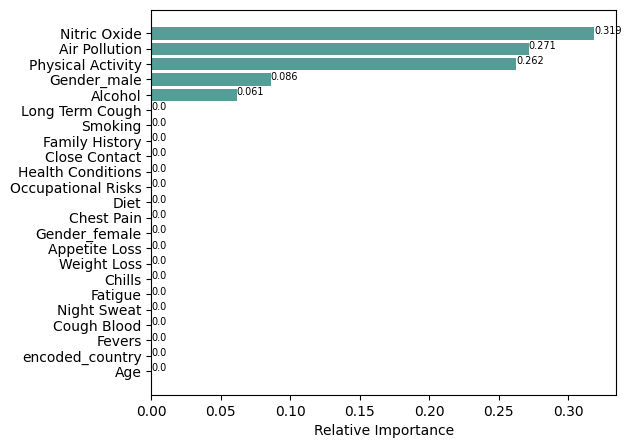

In [386]:
feature_names = X3.columns
target_names = ["0", "1", "2", "3"]

# Get feature importances from the Random Forest model
importances = DT_model.feature_importances_

# Sort the features by importance
indices = np.argsort(importances)

# Create a horizontal bar plot of the feature importances
plt.figure(figsize=(6, 5))
plt.barh(range(len(indices)), importances[indices], color='#559d96', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')

# Add labels to the bars
for i, v in enumerate(importances[indices]):
    plt.text(v, i, str(round(v, 3)), color='black', fontsize= 7)

plt.show()

In [391]:
# Finding optimal hyperparameters(GridSearchCV)

# Define model
model = DecisionTreeClassifier()

# Define evaluation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=0)

# Define search parameters
max_depth = range(2, 19, 1)
criterion = ['entropy', 'gini']   

#min_samples_split = [2, 3, 4]
#min_samples_leaf = [1, 2, 3]

param_grid = {'max_depth': max_depth, 'criterion':criterion}

# Define search
search = GridSearchCV(model, param_grid, scoring='accuracy', n_jobs=-1, cv=cv)

# Execute search
GridSearchCV = search.fit(X_train2, y_train2)

# Set the clf to the best combination of parameters
DT_modelcv = GridSearchCV.best_estimator_

# Summarize result
print('Best Score: %s' % GridSearchCV.best_score_)
print('Best Hyperparameters: %s' % GridSearchCV.best_params_)

Best Score: 0.9120000000000003
Best Hyperparameters: {'criterion': 'entropy', 'max_depth': 12}


In [392]:
DT_modelcv.fit(X_train2, y_train2)

DecisionTreeClassifier(criterion='entropy', max_depth=12)

In [393]:
y_pred4 = DT_modelcv.predict(X_test2)

In [394]:
print('Model accuracy score: {0:0.4f}'. format(accuracy_score(y_test2, y_pred4)))

Model accuracy score: 0.9140


In [395]:
print(classification_report(y_test2, y_pred4))

              precision    recall  f1-score   support

           0       0.94      0.95      0.94       384
           1       0.83      0.78      0.81       116

    accuracy                           0.91       500
   macro avg       0.89      0.87      0.88       500
weighted avg       0.91      0.91      0.91       500



In [396]:
TunedDT_result = metrics_calculator(y_test2, y_pred4, 'Tuned Decision Tree')
TunedDT_result

Tuned Decision Tree
Accuracy              0.914000
Precision             0.885462
Recall                0.868804
F1-score              0.876703

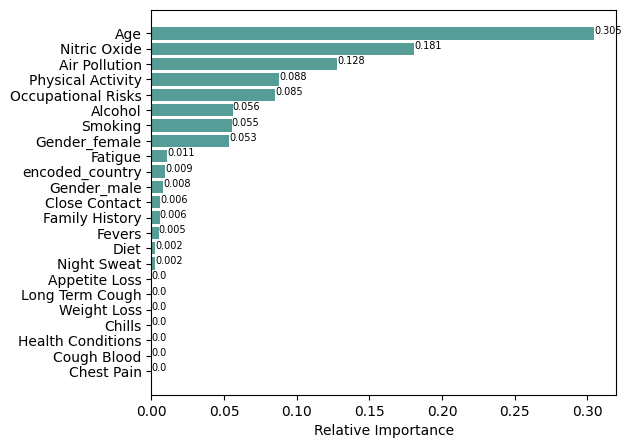

In [397]:
# Get feature importances from the Random Forest model
importances = DT_modelcv.feature_importances_

# Sort the features by importance
indices = np.argsort(importances)

# Create a horizontal bar plot of the feature importances
plt.figure(figsize=(6, 5))
plt.barh(range(len(indices)), importances[indices], color='#559d96', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')

# Add labels to the bars
for i, v in enumerate(importances[indices]):
    plt.text(v, i, str(round(v, 3)), color='black', fontsize= 7)

plt.show()

### Random Forest

In [400]:
X4 = X.drop('tb_pred', axis=1)
Y4 = X['tb_pred'].values.ravel()

In [401]:
# Array of test size value from 0.2 to 0.3
test_size = np.arange(start=0.2, stop=0.35, step=0.05)

# Initialize a list where we'll store the score of each test size
score = []
for size in test_size:
    X_train3, X_test3, y_train3, y_test3= train_test_split (X4, Y4, test_size=size, random_state=0)
    RF_model = RandomForestClassifier ()
    RF_model.fit (X_train3, y_train3)
    score.append (RF_model.score (X_test3, y_test3))
    
# Create a dataframe to display the results   
r= pd.DataFrame({'Test size': test_size, 'Score': score})
r.sort_values(by = ['Score'], ascending = False, inplace = True)
r.style.highlight_max(color='#acd9a8')

In [402]:
# Split X and y into training and testing sets
X_train3, X_test3, y_train3, y_test3 = train_test_split(X4, Y4, stratify=Y4, test_size = 0.25, random_state = 0)

In [403]:
# Instantiate the model
RF_model = RandomForestClassifier()

# Fit the model to the training set
RF_model.fit(X_train3, y_train3)

RandomForestClassifier()

In [405]:
y_pred4 = RF_model.predict(X_test3)
print('Model Accuracy Score: {0:0.4f}'. format(accuracy_score(y_test3, y_pred4)))

Model Accuracy Score: 0.8660


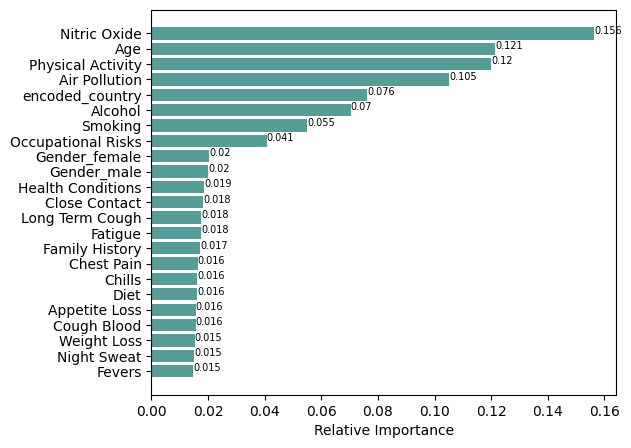

In [407]:
# Get the feature names and class names
fn = X4.columns
cn = ["0", "1", "2", "3"]

# Get feature importances from the Random Forest model
importances = RF_model.feature_importances_

# Sort the features by importance
indices = np.argsort(importances)

# Create a horizontal bar plot of the feature importances
plt.figure(figsize=(6, 5))
plt.barh(range(len(indices)), importances[indices], color='#559d96', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')

# Add labels to the bars
for i, v in enumerate(importances[indices]):
    plt.text(v, i, str(round(v, 3)), color='black', fontsize= 7)

plt.show()

In [416]:
from sklearn.model_selection import GridSearchCV

# define the AdaBoost model with default hyperparameters
ada = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(), random_state=0)

# define the hyperparameters to tune
params = {'n_estimators': [200, 500, 900], 'learning_rate': [0.1, 0.01, 1]}

# base_estimator__max_depth = [1, 2, 3, 4, 5]

# define the grid search using cross validation
grid_search = GridSearchCV(estimator=ada, param_grid=params, cv=10, scoring='accuracy')

# fit the grid search on the data
grid_search.fit(X_train, y_train)

# Set the clf to the best combination of parameters
AdaBoost = grid_search.best_estimator_

# print the best hyperparameters and their corresponding score
print("Best parameters: ", grid_search.best_params_)


Best parameters:  {'learning_rate': 0.1, 'n_estimators': 200}


In [417]:
# fit the AdaBoost model on the training set
AdaBoost.fit(X_train3, y_train3)

# make predictions on the test set and calculate and print the accuracy
predictions4 = AdaBoost.predict(X_test3)
accuracy = metrics.accuracy_score(predictions4, y_test3)
print('Accuracy of the AdaBoost on the test set:', accuracy)

# calculate and print the mean cross-validated score of the AdaBoost model
cross_val_scores = cross_val_score(AdaBoost, X_train3, y_train3, cv=10, scoring='accuracy')
print('The Cross-validated Score for AdaBoost is:', cross_val_scores.mean())

Accuracy of the AdaBoost on the test set: 0.894
The Cross-validated Score for AdaBoost is: 0.9046666666666667


In [418]:
AdaBoost_result = metrics_calculator(y_test3, predictions4, 'Tuned AdaBoost')
AdaBoost_result

Tuned AdaBoost
Accuracy         0.894000
Precision        0.851892
Recall           0.849767
F1-score         0.850821

In [424]:
# Define the GradientBoosting model with default hyperparameters
grad = GradientBoostingClassifier(learning_rate=0.1, random_state=0)

# Define the hyperparameters to tune
parameters = {'n_estimators': [500, 900], 'max_depth': [5, 7]}

#learning_rate = [0.01, 0.1]
#min_samples_split = [2, 5, 10]
#min_samples_leaf = [1, 2, 4]

# Create the grid search object
grid_search = GridSearchCV(grad, parameters, cv=10, scoring='accuracy')

# fit the grid search on the data
grid_search.fit(X_train3, y_train3)

# Set the clf to the best combination of parameters
Gradient_Boosting = grid_search.best_estimator_

# Print the results
print('Best parameters:', grid_search.best_params_)

Best parameters: {'max_depth': 5, 'n_estimators': 500}


In [425]:
# fit the GradientBoosting model on the training set
Gradient_Boosting.fit(X_train3, y_train3)

# make predictions on the test set and calculate and print the accuracy
predictions5 = Gradient_Boosting.predict(X_test3)
accuracy = metrics.accuracy_score(predictions5, y_test3)
print('Accuracy of the GradientBoosting on the test set:', accuracy)

# calculate and print the mean cross-validated score of the GradientBoosting model
cross_val_scores = cross_val_score(Gradient_Boosting, X_train3, y_train3, cv=10, scoring='accuracy')
print('The Cross-validated Score for GradientBoosting is:', cross_val_scores.mean())

Accuracy of the GradientBoosting on the test set: 0.958
The Cross-validated Score for GradientBoosting is: 0.9586666666666666


In [426]:
GradientBoosting_result = metrics_calculator(y_test3, predictions5, 'Tuned Gradient Boosting')
GradientBoosting_result

Tuned Gradient Boosting
Accuracy                  0.958000
Precision                 0.959172
Recall                    0.921516
F1-score                  0.938610

## We will be using the gradient boosting classifier.